In [1]:
from src.System import *

In [2]:
def corresponding_points(l1, l2, M):
    a1, b1 = mTv(M)
    a2, b2 = (calcCD(l1,l2,a1),calcCD(l1,l2,b1))
    return vTm(a2,b2)

def optimize_system(s0:system, T):
    s = s0.clon()
    s.name = s.name + "Opt"
    if len(s.redes)<2:
        return -1
    V_0 = vTm(s.redes[0].a,s.redes[0].b)
    V_s = m2M(V_0,T)
    deformaciones = []
    for i in range(1,len(s.redes)):
        V_i = vTm(s.redes[i].a,s.redes[i].b)
        T_i = corresponding_points(s.redes[0], s.redes[i], T)
        V_i_Op = m2M(V_s,inv2x2(T_i))
        S_i = m2M(inv2x2(V_i),V_i_Op)
        #Guarda la matríz de deformación
        deformaciones.append(S_i)
        #Actualiza la red en la capa con los nuevos vectores primitivos
        a, b = mTv(V_i_Op)
        s.redes[i].setNewVectors(a,b)
        s.redes[i].name = s.redes[i].name + "(Opt)"
    #Creando super Red para el sistema deformado
    s.createSuperLattice(T)
    s.show()
    return s, deformaciones

def calc_def(s:system, T):
    if len(s.redes)<2:
        return None, None
    V_0 = vTm(s.redes[0].a,s.redes[0].b)
    V_s = m2M(V_0,T)
    deformaciones = []
    Ts = []
    for i in range(1,len(s.redes)):
        V_i = vTm(s.redes[i].a,s.redes[i].b)
        #Calculamos la Matriz de trasformación de la capa actual y la guardamos.
        T_i = corresponding_points(s.redes[0], s.redes[i], T)
        Ts.append(T_i)
        #Calculamos la matriz de deformación y la guardamos
        V_i_Op = m2M(V_s,inv2x2(T_i))
        S_i = m2M(inv2x2(V_i),V_i_Op)
        deformaciones.append(S_i)
        print
    return [Ts, deformaciones]

def strain(M:list[list,list]):
    [[a,b],[c,d]] = M
    return det([[a-1,b],[c,d-1]])

def muestra2(s):
    '''
    Muestra una tabla con las caracteristicas de los mejores resultados para las trasnformaciones requeridas para la super Red que describa el sistema r2 sobre r1.
    lor -> Lista de resultados obtenidos de la funciòn 'analiza'
    r1  -> Red1
    r2  -> Red2
    '''
    cont = 1
    for M in s.loMat:
        print("\n**Opción {}. T <- Matriz loMat[{}] del sistema".format(cont,cont-1))
        table = PrettyTable(["Red","T","Deformación","s","#Átomos"])
        res = calc_def(s,M)
        u,v=mTv(m2M(vTm(s.redes[0].a,s.redes[0].b),M))
        print("|Sa|={:.4f},|Sb|={:.4f},Th={:.2f}".format(long(u),long(v),cAng(u,v)))
        err = 0.0
        totalAtms = s.redes[0].nOAtms()*det(M)
        table.add_row(["Capa 0:\n" + s.redes[0].name,
                       mtoStr(M),
                       mtoStr([[1,0],[0,1]]),
                       "{:.3f}%".format(0.0),
                       totalAtms])
        
        for i in range(len(res[0])):
            #print("Calculando numero de atomos multiplicando el numero de atomos en redes[{}] por el det de la matriz en res[0],[{}]".format(i+1,i))
            atms = s.redes[i+1].nOAtms() * det(res[0][i])
            totalAtms += atms
            c_err = strain(res[1][i])*100
            err += abs(c_err)
            table.add_row(["Capa {}:\n".format(i+1) + s.redes[i+1].name,
                           mtoStr(res[0][i]),
                           mtoStr(res[1][i]),
                           "{:.5f}%".format(c_err),
                           atms])
        cont+=1
        print(table)
        print("\t\tTotal de Átomos:{}\tDeformación Promedio:{:.5f}%".format(totalAtms,err/len(res)))


In [ ]:
def analiza_Mat(s:system):
    m0 = [[1.0,0.0],[0.0,1.0]]
    dif = 100.0
    info = []
    for T in s.loMat:
        sa, sb = transforma2v(s.redes[0].a,s.redes[0].b,T)
        for i in range(1, len(s.redes)):
            inf_c = []
            T_i = corresponding_points(s.redes[0],s.redes[i],T)
            sa_i, sb_i = transforma2v(s.redes[i].a,s.redes[i].b,T_i)
            S_i = m2M(m2M(inv2x2(vTm(sa_i,sv_i)), vTm(sa,sb)), inv2x2(T_i))
            d_a, d_b = long(sa_i)/long(sa), long(sb_i)/long(sb)
            t_a, t_b = cAng(sa,sa_i), cAng(sb,sb_i)
            e_a, e_b = dist(sa,sa_i)/long(sa), dist(sb,sb_i)/long(sb)
            #[Mat Ti, Mat Si, error a, error b, def a, def b, ang a, ang b, No Atms]
            inf_c.addend([T_i,S_i,e_a,e_b,d_a,d_b,t_a,t_b,det(T_i)*s.redes[i].nOAtms()])
        info.addend([T,(sa,sb),inf_c])
    return info


In [3]:
bp1 = blackPhospho()
bp2 = blackPhospho()
gr = grafeno()

In [8]:
calc_def(s,s.loMat[0])

[[[[1, 2], [-2, -1]], [[-2, 1], [-5, -3]]],
 [[[0.9999999999999999, 0.0], [0.0, 1.0]],
  [[0.8672991923431843, 0.003086946111155231],
   [-0.022515346550123883, 0.9178482136734973]]]]

In [4]:
s=system([bp1,bp2,gr.mRot(12.4)])

Puntos de red en comun encontrados: 425
--Matriz agregada por resultados 0 y 6
--Matriz agregada por resultados 1 y 12
--Matriz agregada por resultados 2 y 14
--Matriz agregada por resultados 3 y 25
--Matriz agregada por resultados 4 y 38
--Matriz agregada por resultados 5 y 53
--Matriz agregada por resultados 6 y 70
--Matriz agregada por resultados 7 y 89
--Matriz agregada por resultados 8 y 110
--Matriz agregada por resultados 9 y 133
--Matriz agregada por resultados 3 y 12
--Matriz agregada por resultados 7 y 25
--Matriz agregada por resultados 1 y 6
--Matriz agregada por resultados 3 y 13
--Matriz agregada por resultados 7 y 37
--Matriz agregada por resultados 9 y 52
--Matriz agregada por resultados 0 y 6
Posibles Matrices de trasformación calculadas:10
Opción recomendada:
Matriz de trasformación:
	1	2
	-2	-1

Sistema [Black-Phosphorene,Black-Phosphorene,Grafeno(rot 12.4°)] 
Celda unitaria:


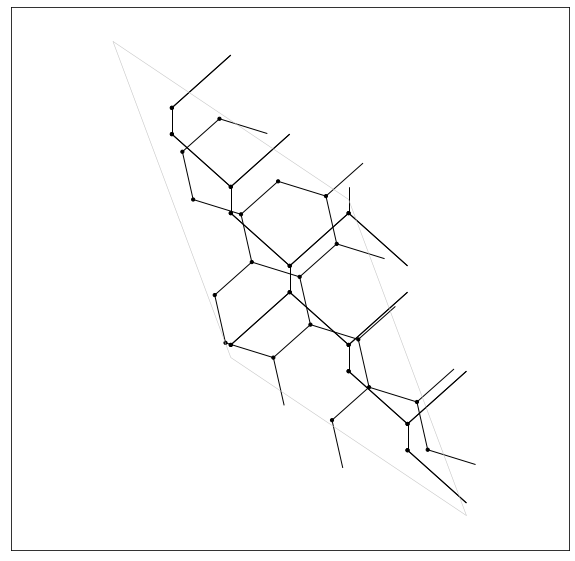

Espacio Reciproco:
Calculando...
...Pintando capa 1 (Black-Phosphorene)
...Pintando capa 2 (Black-Phosphorene)
...Pintando capa 3 (Grafeno(rot 12.4°))
...Terminado


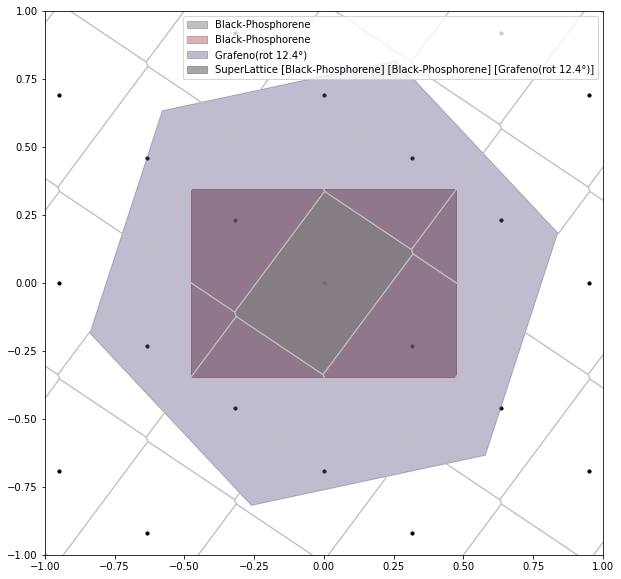

0

In [5]:
s.muestraSR()

In [7]:
muestra2(s)


**Opción 1. T <- Matriz loMat[0] del sistema
|Sa|=9.6865,|Sb|=8.0278,Th=35.50
+--------------------+-------------+---------------------+-----------+---------+
|        Red         |      T      |     Deformación     |     s     | #Átomos |
+--------------------+-------------+---------------------+-----------+---------+
|      Capa 0:       | |   1    2| |     |   1    0|     |   0.000%  |    12   |
| Black-Phosphorene  | |  -2   -1| |     |   0    1|     |           |         |
|                    |             |                     |           |         |
|      Capa 1:       | |   1    2| | |     1.0      0.0| | -0.00000% |    12   |
| Black-Phosphorene  | |  -2   -1| | |     0.0      1.0| |           |         |
|                    |             |                     |           |         |
|      Capa 2:       | |  -2    1| | |  0.8673  0.00309| |  1.09711% |    22   |
| Grafeno(rot 12.4°) | |  -5   -3| | |-0.02252  0.91785| |           |         |
|                    |        

In [ ]:
sr,d=optimize_system(s,s.loMat[0])

In [ ]:
sr.SuperRed.showXY(5,5)

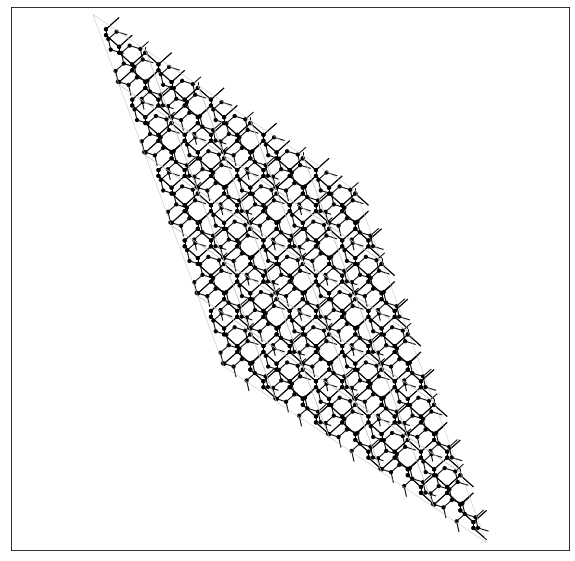

1

In [6]:
s.SuperRed.showXY(5,5)

In [ ]:
sr=superMesh((100,0),(0,100),[bp1,bp2,gr.mRot(12.4)])
sr.showme()

In [ ]:
s.resultados

In [ ]:
u=m2V(bp1.a,bp1.b,(1,2))
v=m2V(bp1.a,bp1.b,(3,1))
u2=m2V(gr.a,gr.b,(4,4))
v2=m2V(gr.a,gr.b,(5,2))
lu1,lu2,lv1,lv2=long(u),long(u2),long(v),long(v2)
u,u2,v,v2,dist(u,u2),dist(v,v2),dist(u,u2)/lu1,dist(v,v2)/lv1

In [ ]:
(calcCD(bp1,gr,(1,2)),calcCD(bp1,gr,(3,1)))

In [ ]:
sr=superMesh(u,v,[bp1,bp2,gr.mRot(12.4)])
sr.showXY(5,5)

In [ ]:
sl=importa("slab_332")
g =importa("Graf(CellMatch)")

In [ ]:
s=system([sl,g,g.mRot(15.3)])

In [ ]:
muestra2(s)

In [ ]:
s.muestraSR(eps=0.05)

In [ ]:
s.resultados

In [ ]:
Gr=importa("gr")
Gr.name="Grafene"
hBn=importa("hBn")
hBn.name="hBN"
Ph=importa("Ph")
Ph.name="Ph"

In [ ]:
hpg=system([hBn,Ph.mRot(3.8),Gr.mRot(18.1)])
hpg.muestraSR(range_search=30,eps=0.03)

In [ ]:
muestra2(hpg)

In [ ]:
hpg.SuperRed.exporta()

In [ ]:
s=system([grafeno(),grafeno().mRot(13.17),grafeno().mRot(21.78)])

In [ ]:
M=[[6,13],[36,47]]
hpg.createSuperLattice(M)
hpg.show()

In [ ]:
sp=superMesh((100,0),(0,100),[hBn,Ph.mRot(3.8),Gr.mRot(18.1)])
sp.showme()

In [ ]:
s.muestraSR()

In [ ]:
sr1=s1.SuperRed
s2=system([sr1,grafeno().mRot(21.78)])

In [ ]:
s2.muestraSR()

In [ ]:
def its_hexagonal_system(self):
    '''
    Señala si el sistema está conformado sólo por redes hexagonales.
    '''
    err = 10**-6
    for r in self.redes:
        if abs(120.0-r.inAngle)>err:
            return False
    return True

In [ ]:
s0=system([grafeno(),grafeno3(),hexa6(1.26),blackPhospho()])
its_hexagonal_system(s0)

In [ ]:
hpg2, dfm = optimize_system(hpg,hpg.loMat[0])

In [ ]:
V_0 = vTm(hpg2.redes[0].a,hpg2.redes[0].b)
V_s = m2M(V_0,hpg.loMat[0])
u,v = mTv(V_s)
print("Vectores esperados:{},{}".format(u,v))
for i in range(1,len(hpg2.redes)):
    V_i = vTm(hpg2.redes[i].a,hpg2.redes[i].b)
    T_i = corresponding_points(hpg2.redes[0], hpg2.redes[i],hpg.loMat[0])
    u,v = mTv(m2M(V_i,T_i))
    print("Vectores capa{}:{},{}".format(i,u,v))

In [ ]:
V_0 = vTm(hpg.redes[0].a,hpg.redes[0].b)
V_s = m2M(V_0,hpg.loMat[0])
u,v = mTv(V_s)
print("Vectores esperados:{},{}".format(u,v))
for i in range(1,len(hpg2.redes)):
    V_i = vTm(hpg.redes[i].a,hpg.redes[i].b)
    T_i = corresponding_points(hpg.redes[0], hpg.redes[i],hpg.loMat[0])
    u,v = mTv(m2M(V_i,T_i))
    print("Vectores capa{}:{},{}".format(i,u,v))

In [ ]:
muestra2(hpg)

In [ ]:
muestra2(hpg2)

In [ ]:
mtoStr([[5.2222,3.4581001],[7,6]])

In [ ]:
strS(5.2222)

In [ ]:
type(5.2222)

In [ ]:
hpg.resultados

In [ ]:
(c,d) = calcCD(hpg.redes[0],hpg.redes[1],(7, 11))
p_1 = m2V(hpg.redes[0].a,hpg.redes[0].b,(7, 11))
p_2 = m2V(hpg.redes[1].a,hpg.redes[1].b,(c,d))
dist(p_1,p_2)

In [ ]:
cAng(m2V(hpg.redes[0].a,hpg.redes[0].b,(7, 11)),m2V(hpg.redes[0].a,hpg.redes[0].b,(26, -2)))

In [ ]:
hpg.SuperRed.reciprocalVectors

In [ ]:
hpg2.SuperRed.reciprocalVectors

In [ ]:
hpg2.SuperRed.exporta()
hpg.SuperRed.exporta()

In [ ]:
va,vb,th=hpg2.redes[2].a,hpg2.redes[2].b, cAng(hpg2.redes[2].a,hpg2.redes[2].b)
print("Red Grafeno Optimizada:\n\t a={},b={}\n\t|a|={:.5f},|b|={:.5f},Theta={:.5}".format(va,vb,long(va),long(vb),th))

In [ ]:
va,vb,th=hpg.redes[2].a,hpg.redes[2].b,cAng(hpg.redes[2].a,hpg.redes[2].b)
print("Red Grafeno Original:\n\ta={},b={}\n\t|a|={:.5f},|b|={:.5f},Theta={:.5f}".format(va,vb,long(va),long(vb),th))

In [ ]:
s,d=strain([[1.002,0.004],[0.002,0.994]]), det([[1.002,0.004],[0.002,0.994]])
s/det(vTm(hpg.redes[0].a,hpg.redes[0].b))

In [ ]:
def cosa(d,t):
    th=t*math.pi/180
    return strain([[d*math.cos(th),-d*math.sin(th)],[d*math.sin(th),d*math.cos(th)]])

In [ ]:
thetas = []
dif = []
strains = []
for i in range(1800):
    ths = []
    di = []
    st = []
    for j in range(401):
        d = j/100
        th = i/10
        s = cosa(d,th)
        ths.append(th)
        di.append(d)
        st.append(s)
        #print("Dif={},Theta={}º \n\tstrain={}\n".format(d,th,s))
    thetas.append(ths)
    dif.append(di)
    strains.append(st)
thetas = np.array(thetas)
dif = np.array(dif)
strains = np.array(strains)

In [ ]:
fig= plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(dif,thetas,strains,cmap='viridis',alpha=0.9)
plt.show()

In [ ]:
len(X[0])

In [ ]:
def calcCD2(vs, us, ab):
    '''
    Dadas 2 redes 'substrate' y 'layer' calcula los enteros 'c' y 'd' tales que para los
    vectores primitivos de 'substrate' (u,v) y los vectores primitivos de 'layer' (p,q)
    \$p'= cp + dq\$, aproxime a \$p = au + bv\$.
    substrate -> Red base.
    layer     -> Red por aproximar
    ab        -> Pareja de enteros que definen al vector que queremos aproximar
    '''
    (a,b) = ab
    (u,v), (p,q) = vs, us
    (u_1,u_2), (v_1,v_2) = u, v
    (p_1,p_2), (q_1,q_2) = p, q
    eq0 = (p_2*q_1)-(p_1*q_2)
    eq1 = (q_1*u_2)-(q_2*u_1)
    eq2 = (q_1*v_2)-(q_2*v_1)
    eq3 = (p_2*u_1)-(p_1*u_2)
    eq4 = (p_2*v_1)-(p_1*v_2)
    c = ((eq1*a)+(eq2*b))/(eq0)
    d = ((eq3*a)+(eq4*b))/(eq0)
    return (round(c),round(d)),(c,d)

In [ ]:
u,v,p,q = (7.23,1.13),(-2.1,6.25),(2.98,5.2),(-8.225,-0.98)

In [ ]:
r1 = grafeno()
r2 = grafeno()
r1.setNewVectors(u,v)
r2.setNewVectors(p,q)

In [ ]:
s = system([r1,r2])

In [ ]:
s.muestraSR()

In [ ]:
a1,b1,a2,b2 = 5,7,2,3
(c1,d1),(cx1,dx1)=calcCD2((u,v),(p,q),(a1,b1))
(c2,d2),(cx2,dx2)=calcCD2((u,v),(p,q),(a2,b2))
c1,d1,c2,d2,cx1,dx1,cx2,dx2

In [ ]:
m2V(u,v,(a1,b1)),m2V(p,q,(c1,d1))

In [ ]:
s.redes[1].b

In [ ]:
corresponding_points(r1,r2,s.loMat[0])

In [ ]:
transforma2v(u,v,s.loMat[0])

In [ ]:
transforma2v(p,q,[[-4, 3], [-3, 1]])

In [ ]:
s.loMat[0]

In [ ]:
s.resultados

In [ ]:
muestra2(s)

In [ ]:
calc_def(s,s.loMat[0])

In [ ]:
s2,d=optimize_system(s,s.loMat[0])

In [ ]:
for r in s2.redes:
    print("\n",r.name)
    print(r.a)
    print(r.b)

In [ ]:
for r in s.redes:
    print("\n",r.name)
    print(r.a)
    print(r.b)

In [ ]:
u=(2.98, 5.2)
v=(2.995384615384616, 5.0223076923076935)

In [ ]:
long(v)/long(u)

In [ ]:
cAng(u,v)

In [13]:
A=[[1,2],[3,5]]
B=[[3,5],[-1,3]]
A=np.array(A)
B=np.array(B)
(A+B).tolist(), (5*A).tolist()

([[4, 7], [2, 8]], [[5, 10], [15, 25]])

In [14]:
def multM(M,x):
    '''
    Multiplica la matriz M por una constante x
    '''
    xM=x*np.array(M)
    return xM.tolist()

def sumaM(A,B):
    '''
    Suma las matrices A y B
    '''
    C = np.array(A)+np.array(B)
    return C.tolist()

In [19]:
pmat(sumaM(A,multM(B,-1)))

	-2	-3
	4	2

